<a href="https://colab.research.google.com/github/pranshu-45/K-MeansClustering_AudioDataset_DA623/blob/main/Audio_Signal_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

KMeans is a popular clustering algorithm in machine learning that groups similar data points together to discover underlying patterns in the data

1. Initial Centroid Selection:

    KMeans starts by randomly placing K centroids in our data space, where K is the number of clusters we want to find. These centroids are like the initial guesses of where the clusters might be.

2. Assigning Data Points to Clusters:

    Next, KMeans looks at each data point and assigns it to the nearest centroid. This step is like assigning each data point to a detective (centroid) who will investigate its cluster.

3. Updating Centroids:

    After assigning all data points, each centroid now has a group of data points assigned to it. The centroids are then updated to the average position of all the data points in their cluster. This step helps the centroids move closer to the true centers of the clusters.

4. Iteration:

    KMeans repeats the assignment and updating steps until the centroids no longer change significantly. This iterative process allows KMeans to find the best clusters for our data.

5. Finding Clusters:

    Once KMeans converges, we have our clusters! Each data point belongs to the cluster with the nearest centroid, and the centroids represent the centers of the clusters.

6. Applications:

    KMeans is used in various real-world applications, such as customer segmentation, where businesses group customers based on their purchasing behavior, or in image compression, where similar colors are grouped together to reduce file size.

7. Things to keep in mind:

    It's important to choose the right number of clusters, K, which can sometimes be challenging. Techniques like the elbow method, silhouette score can help us find the optimal K.

# K-Means Clustering on audio dataset

We will see how the algorithm runs for an audio dataset. Some specifications that you should see before seeing this code are listed below.

## Sample Space

* There are 60 samples for our experiment.
* Each sample is a 3-4 second .wav file containing a note played on a piano. Piano is also capable of producing sounds that other instruments would typically have, so the sample space contains sounds of same note played on different instruments.
* I have recorded the data myself. There are 4 notes which I played, each having 15 samples. There are 5 different instruments on which each note is played, so one note on one instrument is recorded 3 times.
* We have uploaded the audio files on google drive and linked pynb to it.

## Cluster size determination

* I have displayed both elbow method and silhouette score to determine the appropriate number of cluster needed.
* Ultimately, we proceed with cluster size returned by the elbow method

## Results

* Results at the end are shown in the form of points being plotted on 2d plane by reducing the dimensions using PCA.
* The frequencies of dominant notes are calculated for a cluster and presented

## Short-comings

* Their are significant errors in the pre-processing library used where each note isn't constituted correctly over the 12 musical notes. This would be displayed later, where we add the correct labels and instruments and find that dominant note identified is different to the note recorded.
* Even though the pre-processing is a bit faulty, the clustering algorithm works perfectly fine and makes clusters based on the dominant notes.



## Installing dependencies for the program


In [263]:
!pip install eyed3
!pip install pyAudioAnalysis
!pip install pydub

In [264]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import eyed3
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import scipy.io.wavfile as wavfile  # Import for WAV file reading
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import itertools
import os

from google.colab import drive
drive.mount('/content/gdrive')
dataset_path = "/content/gdrive/My Drive/My_Samples/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Pre-processing the audio files

1. Pre-process data and transform double channel to single channel:

    * Imagine sound as a wave. Stereo audio uses two channels to represent this wave, like two ripples traveling side-by-side. This can be useful for spatial sound effects.

    * Pre-processing: This step might involve cleaning up the audio data. For example, removing background noise or ensuring the data is in the correct format for further processing.

    * Double channel to single channel: Since I am interested in the musical notes rather than spatial effects, converting the audio from two channels (stereo) to one chanel (mono) can simplify the analysis. This essentially combines the two sound waves into a single wave, focusing on the overall sound information.

2. Extract the chromagram from the audio file:

    * Imagine a piano keyboard. Each key represents a specific musical note. A chromagram is like a fingerprint of the music. It tells you how much energy exists in each note (or a group of notes) over time.

    * Extracting the chromagram: This step involves analyzing the audio data to determine how much "musical energy" exists at each note or group of notes throughout the audio. This information is compressed into the chromagram, providing a simpler representation of the music's pitch content.

3. Find note frequency:

    * Now that I have the chromagram, it's like having a map of the notes present in the music.

    * Finding note frequency: This step involves analyzing the chromagram to determine how often each note appears (or how much energy is present for each note) over time. This gives you an idea of which notes are dominant and how frequently they occur in the music.

In [265]:
def preProcess(fileName):

    # Read the WAV file using scipy.io.wavfile.read
    try:
        Fs, x = wavfile.read(fileName)
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None, None  # Return None for both Fs and x if there's an error

    # Handle multi-channel audio (if necessary)
    if len(x.shape) > 1 and x.shape[1] == 2 :
        # Assuming stereo (2 channels), take the mean across channels
        x = np.mean(x, axis=1, keepdims=True)
    else:
        # Ensure single channel (reshape if needed)
        x = x.reshape(x.shape[0], 1)

    # Feature extraction (assuming you have a suitable function)
    try:
        # Replace with your actual feature extraction function
        # (e.g., from a library like librosa)
        F, f_names = ShortTermFeatures.feature_extraction(x[:, 0], Fs, 0.050*Fs, 0.025*Fs)
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return None, None  # Return None for both f_names and F if there's an error

    return f_names, F

In [266]:
def getChromagram( audioData ):

    if audioData is None:
        print("Error: audioData is None")
        return None  # Or handle the error differently

    # chronograph_1
    temp_data =  audioData[ 21 ].reshape( 1, audioData[ 21 ].shape[0] )
    chronograph = temp_data

    # looping through the next 11 stacking them vertically
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 1, audioData[ i ].shape[0] )
        chronograph = np.vstack( [ chronograph,  temp_data ] )

    return chronograph

In [267]:
def getNoteFrequency( chromagram ):

    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1]

    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )

    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = 12 )

    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows

    return normalized_hist

## Utility function to plot a heat map and frequency of each note

Heatmaps:
* Heatmaps are a type of visualization used to represent data as a color  gradient. Colors generally range from cool (blues, greens) to warm (yellows, reds) to depict intensity or frequency.

Plotting Heatmaps of Chromagrams:

  * Axes: One axis of the heatmap typically represents time (horizontal) and the other axis represents musical pitch (vertical). You can further subdivide the pitch axis into individual notes (C, C#, D, etc.) or groups of notes (e.g., chromatic steps or chords).
      
  * Color Intensity: The intensity of each color in the heatmap corresponds to the strength or frequency of a particular note at a specific point in time. Higher intensity (warmer colors) indicates a stronger presence of that note at that time. Conversely, cooler colors represent weaker presence. Here we record all the samples at same pitch and amplitude, so no changes are observed over samples.
      
Insights: By analyzing the heatmap, we can:
    
  * Identify prominent notes or chords throughout the music.
      Observe changes in pitch content over time (e.g., transitions between different sections of a song).
      Compare chromagrams of different audio files to visually see similarities or differences in their musical content.

In [268]:
def plotHeatmap( chromagraph, smallSample = True ):

    notesLabels = [ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]

    fig, axis = plt.subplots()

    if smallSample:
        im = axis.imshow( chromagram[ :, 0 : 25 ], cmap = "YlGn" )
    else:
        im = axis.imshow( chromagram )

    cbar = axis.figure.colorbar(im, ax = axis,  cmap = "YlGn")
    cbar.ax.set_ylabel("Amplitude", rotation=-90, va="bottom")

    axis.set_yticks( np.arange( len(notesLabels) ) )
    axis.set_yticklabels(notesLabels)

    axis.set_title( "chromagram" )

    fig.tight_layout()
    _ = plt.show()

In [269]:
def noteFrequencyPlot( noteFrequency, smallSample = True ):

    fig, axis = plt.subplots(1, 1, sharey=True )

    axis.plot( np.arange( 1, 13 ), noteFrequency[0, :] )

    _ = plt.show()

## Dataset generation

* Iterate over the audio files in the folder and pre-process them
* Identifies the notes present in the .wav file

In [270]:
fileList = []

def getDataset( filePath ):
    X = pd.DataFrame(  )

    columns=[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]

    for root, dirs, filenames in os.walk( filePath ):
        for file in filenames:
            fileList.append( file )
            feature_name, features = preProcess(filePath + file )
            chromagram = getChromagram( features )
            noteFrequency = getNoteFrequency( chromagram )
            x_new =  pd.Series(noteFrequency[ 0, : ])
            X = pd.concat( [ X, x_new ], axis = 1 )
            # X.loc[X.index[-1], "filename"] = file  # Add filename to the last row

    data = X.T.copy()
    data.columns = columns
    data.index = [ i for i in range( 0, data.shape[ 0 ] ) ]

    return data

## Sample pre-processing, plotting of heatmap and note frequency

In [271]:
file_path = dataset_path + "AUDIO029.wav"
feature_name, features = preProcess( file_path )

Note the constant amplitude of all the signals, as we have recorded the samplesf from piano at same volume level

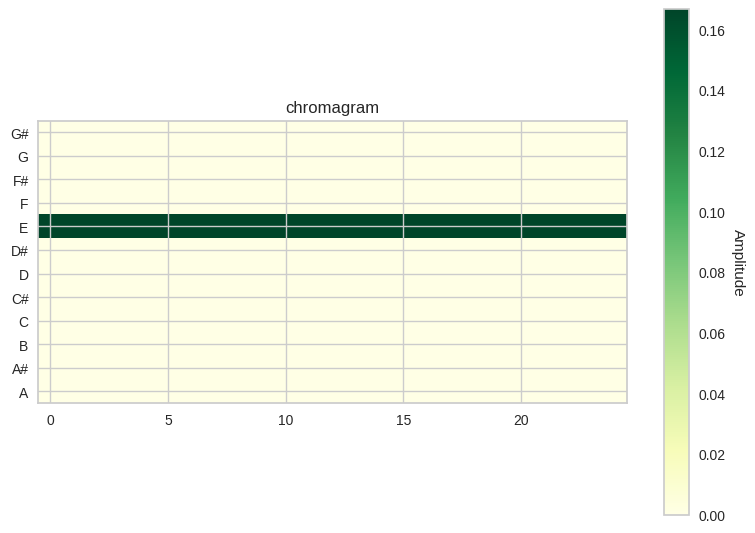

In [272]:
chromagram = getChromagram( features )
plotHeatmap( chromagram )

* The plot  likely displays notes on the x-axis and their corresponding frequencies on the y-axis.
* The visualization helps us see which notes are most frequent (dominant) in the analyzed audio based on the chromagram data.

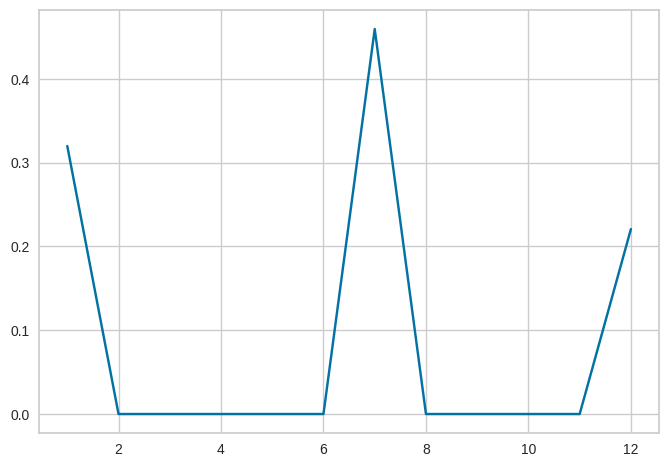

In [273]:
noteFrequency = getNoteFrequency( chromagram )
noteFrequencyPlot( noteFrequency )

## Populating the Sample dataset
*   Passing the path of sample data files
*   Iterating over each sample and pre-processing it



In [274]:
data = getDataset( dataset_path )

## Elbow method

* Imagine I have a bunch of data points, and I'm trying to figure out how many groups, or clusters, these points naturally form. The elbow method is a simple but powerful technique to help me decide the optimal number of clusters to use.

* First, I would run my clustering algorithm (like KMeans) with different numbers of clusters, let's say from 1 to 10. For each run, I calculate a measure of how well the data points fit into the clusters, like the sum of squared distances from each point to its cluster center (called the "inertia" in KMeans). I then plot these values on a graph, with the number of clusters on the x-axis and the measure of fit on the y-axis.

* When I plot the graph, I'll often see a point where the measure of fit decreases sharply and then starts to level off, forming a shape like an elbow. This "elbow point" is where the addition of more clusters doesn't significantly improve the fit of the data.

* The number of clusters at the elbow point is considered the optimal number of clusters for my data. It's a balance between having enough clusters to capture the nuances in the data and not having too many clusters, which can lead to overfitting.

* In essence, the elbow method helps me find that sweet spot where I have just the right number of clusters to describe my data effectively.

### Distortion Score

* The distortion score measures the total squared distance between each data point and its assigned cluster center.

* In simpler terms, it represents how well-separated the clusters are. Lower distortion scores indicate tighter clusters, where data points are closer to their respective cluster centers.

* Conversely, higher distortion scores suggest scattered clusters, where data points might be farther from their assigned centers.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

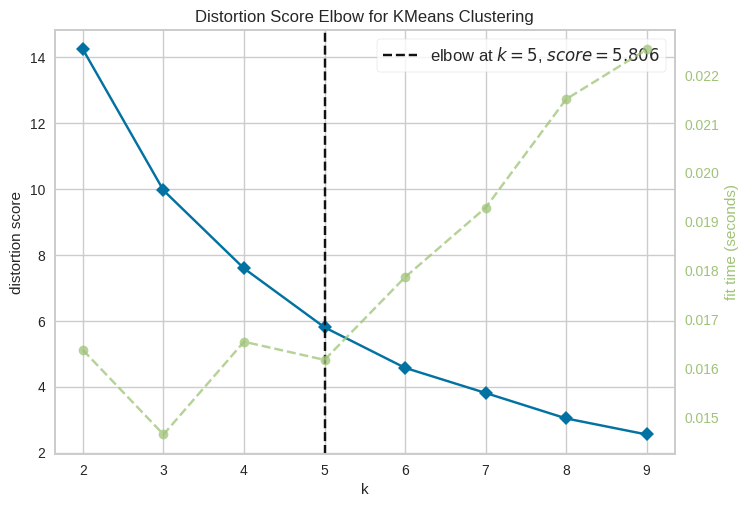

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [275]:
# Assuming your data is in 'data'
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))  # Choose a range of k values
visualizer.fit(data)
visualizer.show()

## Silhouette Score

* In K-Means clustering, silhouette score helps assess cluster quality. It considers both the compactness within a cluster and separation between clusters for each data point.


Distances:

  * I calculate the distance between a data point and its nearest neighbors within its assigned cluster (intra-cluster distance).
  * I also calculate the distance to the closest data point in a different cluster (inter-cluster distance).

Silhouette Score:
      
  * A high "I" value for a data point signifies it's well-placed within its cluster (small intra-cluster distance) and far from points in other clusters (large inter-cluster distance).
  * A low "I" value suggests the data point might be closer to points in another cluster, indicating a potentially poor placement.

Average Silhouette Score:

  * I calculate "I" for all data points and then average it across all points.
  * A high average "I" value suggests good overall cluster separation, where data points are well-grouped within their clusters with clear separation between different clusters.


Thus the best number of cluster size is given by the highest silhouette score closest to 1.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

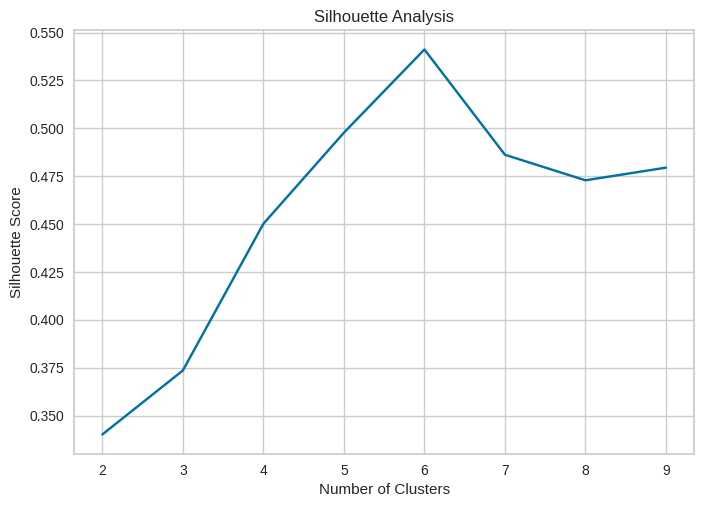

Optimal number of clusters based on Silhouette Analysis: 6


In [276]:
silhouette_scores = []
for k in range(2, 10):  # Choose a range of k values (adjust as needed)
  kmeans = KMeans(n_clusters=k)
  cluster_labels = kmeans.fit_predict(data)
  silhouette_score_val = silhouette_score(data, cluster_labels)
  silhouette_scores.append(silhouette_score_val)

# Plot silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

# Find the index of the maximum score
max_score_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = max_score_index + 2  # Because range starts from 2

print(f"Optimal number of clusters based on Silhouette Analysis: {optimal_k}")


##  Choosing cluster size based on elbow method

In [277]:
# Number of cluster we wish to divide the data into( user tunable )
k = 5

# Max number of allowed iterations for the algorithm( user tunable )
epochs = 2000

## Initialize centroids for starting the algorithm

In [278]:
def initilizeCentroids( data, k ):
    '''
    Initilize cluster centroids( assuming random k data points to be centroid return them )
    '''
    centroids = data[ 0 : k ]
    return centroids

## Functions to assign data points to centroids and recalculate centroids

In [279]:
X = tf.placeholder( dtype = tf.float32 )
C = tf.placeholder( dtype = tf.float32 )
C_labels = tf.placeholder( dtype = tf.int32 )

# utility to assign centroids to examples
expanded_vectors = tf.expand_dims( X, 0 )
expanded_centroids = tf.expand_dims( C, 1 )
distance = tf.reduce_sum( tf.square( tf.subtract( expanded_vectors, expanded_centroids ) ), axis = 2 )
getCentroidsOp = tf.argmin( distance, 0 )


# utility to recalculate centroids
sums = tf.unsorted_segment_sum( X, C_labels, k )
counts = tf.unsorted_segment_sum( tf.ones_like( X ), C_labels, k  )
reCalculateCentroidsOp = tf.divide( sums,  counts )

## Driver function

In [280]:
centroids = []
data_labels = []

with tf.Session() as sess:

    # Initilize all tensor flow variables
    sess.run( tf.global_variables_initializer() )

    # Get initial list of k centroids
    centroids = initilizeCentroids( data, k )

    for epoch in range( epochs ):
        data_labels =  sess.run( getCentroidsOp, feed_dict = { X: data, C: centroids } )
        centroids = sess.run( reCalculateCentroidsOp, feed_dict = { X: data, C_labels: data_labels } )

print( data_labels )
print( centroids )

[0 1 0 3 4 2 2 2 3 1 2 1 1 4 1 1 1 4 1 2 0 1 1 3 0 3 2 1 0 2 1 2 2 4 0 2 2
 1 2 4 1 2 3 3 0 1 2 1 1 2 2 1 2 2 0 3 3 1 2 1]
[[2.0531686e-01 0.0000000e+00 0.0000000e+00 1.6892916e-01 0.0000000e+00
  0.0000000e+00 4.4087180e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.8488219e-01]
 [2.0483370e-01 0.0000000e+00 0.0000000e+00 3.0864199e-04 0.0000000e+00
  0.0000000e+00 1.6521581e-02 4.7732364e-02 3.2716047e-02 0.0000000e+00
  1.7127339e-02 6.8076026e-01]
 [5.2201194e-01 5.4355457e-02 6.5539149e-04 0.0000000e+00 8.3385080e-02
  3.4789354e-02 2.1443056e-02 0.0000000e+00 0.0000000e+00 1.4679556e-02
  1.3261609e-01 1.3606411e-01]
 [6.8263412e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 8.8073188e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 5.1004663e-02]
 [9.2436835e-02 0.0000000e+00 1.3605442e-03 0.0000000e+00 6.8846977e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 2.1773288e-01]]


## Adding generated labels and audio names with the data

In [281]:
# print(len(data_labels))
# print(len(fileList))
final_labels = pd.DataFrame( { "Labels": data_labels, "File Names": fileList } )
# final_labels
# # data_with_filenames = np.concatenate((data, fileList[:, None]), axis=1)


## Utility function

* The basic intuition is that clusters are formed on the basis of dominating note each sample has
* The function calculates dominating note and adds a field in the data

In [282]:
def find_dominant_column(row):
  """
  Finds the column name with the dominating value in a DataFrame row.

  Args:
      row: A pandas Series representing a single row of the DataFrame.

  Returns:
      The column name with the dominating value, or None if there's a tie.
  """
  # Find the maximum value in the row
  max_value = row.max()

  # Count the number of occurrences of the maximum value
  max_value_count = (row == max_value).sum() - 1  # Subtract 1 to exclude the max value itself

  # Check if there's a tie for the maximum value
  if max_value_count > 0:
    return None  # Tie situation
  else:
    # Get the column name with the dominating value
    return row.idxmax()

# Assuming your data is in a DataFrame named 'data' and your note columns are named G#, G, etc.
dominant_notes = []
for index, row in data.iterrows():
  dominant_column = find_dominant_column(row)
  dominant_notes.append(dominant_column)

# Directly add the 'Dominant Note' column with dominant column names
dominant_notes_series = pd.Series(dominant_notes, name='Dominant Note')

# Concatenate the DataFrame and Series along the axis (columns in this case)
dominating_note_added = pd.concat([data, dominant_notes_series], axis=1)

## Adding true data labels and identifying dominating node

* Note the difference in the dominant notes identified by the libraries and the one which was truly played.
* Notes were played in the fashion specified below, which we merge with the audio files in the serial order

In [283]:
labels = itertools.cycle(["D", "G", "A#", "C#"])  # Cycle through labels A, B, C, D
instruments = itertools.cycle(["Grand Piano", "Cool Organ", "Clean Guitar", "Flute"])  # Cycle through labels A, B, C, D
notes_result = []
instrument_result = []

for i in range(60):
    if i % 15 == 0:
        current_note_label = next(labels)  # Get the next label
    if i % 3 == 0:
        current_instrument_label = next(instruments)
    notes_result.append( current_note_label)
    instrument_result.append( current_instrument_label)

true_labels = pd.DataFrame( { "True Note Labels": notes_result, "True Instrument Labels":instrument_result  } )

In [284]:

data_with_filename = pd.concat([dominating_note_added, final_labels], axis=1)

sorted_data = data_with_filename.sort_values(by="File Names").reset_index(drop=True)


## Viewing the data after clustering

In [285]:
true_data = pd.concat([sorted_data.reset_index(drop=True), true_labels], axis=1)
true_data = true_data.sort_values(by="Labels")
true_data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A,Dominant Note,Labels,File Names,True Note Labels,True Instrument Labels
0,0.299435,0.000000,0.000000,0.000000,0.000000,0.000000,0.435028,0.000000,0.000000,0.000000,0.000000,0.265537,D,0,AUDIO028.wav,D,Grand Piano
37,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.580247,0.000000,0.000000,0.000000,0.000000,0.308642,D,0,AUDIO065.wav,A#,Grand Piano
38,0.118644,0.000000,0.000000,0.604520,0.000000,0.000000,0.271186,0.000000,0.000000,0.000000,0.000000,0.005650,F,0,AUDIO066.wav,A#,Grand Piano
51,0.387755,0.000000,0.000000,0.000000,0.000000,0.000000,0.605442,0.000000,0.000000,0.000000,0.000000,0.006803,D,0,AUDIO079.wav,C#,Cool Organ
36,0.115646,0.000000,0.000000,0.000000,0.000000,0.000000,0.496599,0.000000,0.000000,0.000000,0.000000,0.387755,D,0,AUDIO064.wav,A#,Grand Piano
33,0.024691,0.000000,0.000000,0.746914,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.006173,F,0,AUDIO061.wav,A#,Flute
1,0.319820,0.000000,0.000000,0.000000,0.000000,0.000000,0.459459,0.000000,0.000000,0.000000,0.000000,0.220721,D,0,AUDIO029.wav,D,Grand Piano
2,0.265432,0.000000,0.000000,0.000000,0.000000,0.000000,0.456790,0.000000,0.000000,0.000000,0.000000,0.277778,D,0,AUDIO030.wav,D,Grand Piano
6,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360544,0.000000,0.000000,0.000000,0.619048,A,1,AUDIO034.wav,D,Clean Guitar
26,0.340136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210884,0.448980,A,1,AUDIO054.wav,G,Grand Piano


## Applying PCA to visualize points in 2D plane

Imagine we have a bunch of data points scattered around in high dimensions (think 3D, 4D, or even more). PCA (Principal Component Analysis) helps us visualize them in a simpler way. Here's how:

Finding Major Directions:

* PCA analyzes the data and identifies the most important directions of variation in those high dimensions. Think of these directions like "highways" where most of the data points lie.

Compressing Data:

* PCA takes those major directions and uses them to create a new, lower-dimensional space (often 2D for visualization). It projects the data points onto these new directions, essentially compressing the information.

Visualization:

* Now we have the data points projected onto this lower-dimensional space. This allows us to plot them on a 2D plane (like a regular graph) and see how they are distributed based on the most important variations in the original high-dimensional data.

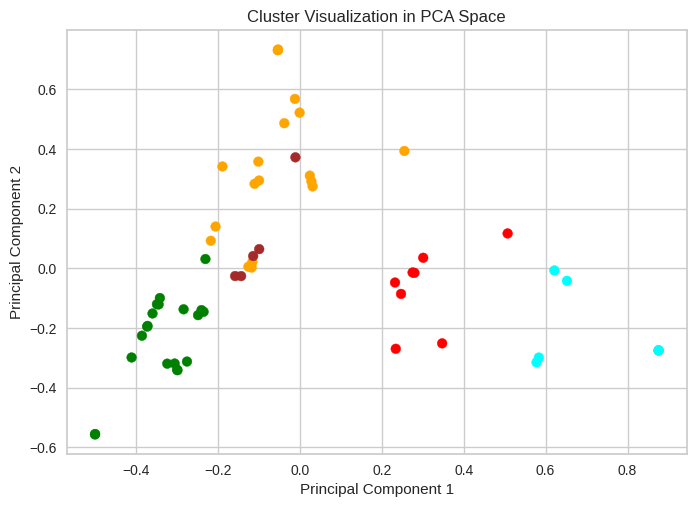

In [286]:
freq_data = true_data.iloc[:, :12]
pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_data = pca.fit_transform(freq_data)

# Extract the cluster labels from 'true_data'
cluster_labels = true_data.iloc[:, 13].values  # Assuming cluster labels are in the 14th column

num_clusters = len(set(cluster_labels))  # Assuming cluster_labels contains integer labels
cmap = colors.ListedColormap(['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'brown'])  # Replace with your desired colors

# Use first two principal components for visualization
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization in PCA Space')
plt.show()

## Analysing results of clustering

* We list the frequencies of dominant notes in the sample in each cluster
* We can see that each cluster is formed on the basis of dominating note
* Three clusters are seen to have purely one dominating note
* Two classes have some anomaly with still the dominating note dominating in the frequencies too.


In [287]:
def note_frequency_per_label(data, label_column_name, dominant_note_column_name):
  """
  Calculates the frequency of each note for each label in a DataFrame.

  Args:
      data: The pandas DataFrame containing labels and dominant notes.
      label_column_name: The name of the column containing labels.
      dominant_note_column_name: The name of the column containing dominant notes.

  Returns:
      A pandas DataFrame with labels as the index and columns for each note
      showing their frequencies within each label.
  """

  # Group data by label
  grouped_data = data.groupby(label_column_name)

  # Count occurrences of each note within each label group
  note_counts = grouped_data[dominant_note_column_name].value_counts().unstack(fill_value=0)

  return note_counts

# Assuming your DataFrame is named 'data'
note_frequencies = note_frequency_per_label(true_data, 'Labels', 'Dominant Note')

# Print the DataFrame with note frequencies per label
note_frequencies


Dominant Note,A,A#,D,E,F,G,G#
Labels,,,,,,,
0,0,0,6,0,2,0,0
1,20,0,0,0,0,0,0
2,1,3,0,0,0,3,12
3,0,0,8,0,0,0,0
4,0,0,0,5,0,0,0


# Thus we can conclude that k-means algorithm works in a correct fashion over the data samples and identifies clusters based on the notes dominating in the sample.
# The distinguishness over other such analysis available online is in the domain of sample space, where i myself record the samples.